<a href="https://colab.research.google.com/github/FennicOculus/Image-translation/blob/main/AnimeFaceReconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

i run this notebook a lot so the following variable is used so i can run all the notebook at once without training the model if i don't want to X)

In [ ]:
wannaTrain = False
downloaded = False
scratch = False

#Downloading Dataset

In [ ]:
!cp -r /content/drive/MyDrive/Kaggle/kaggle.json /content

In [ ]:
! pip install -q kaggle

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

I used the anime face dataset on [Kaggle](https://www.kaggle.com/datasets/splcher/animefacedataset) provided by splcher

In [ ]:
if not downloaded:
  !kaggle datasets download 'splcher/animefacedataset'
  !unzip animefacedataset.zip

#Importing Libraries

In [ ]:
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras import backend as K
from keras.layers import Rescaling, Resizing
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback, TensorBoard
from keras import regularizers
import numpy as np
import os
import datetime
import gc #garbage collector
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2
import psutil

In [ ]:
!rm -rf ./logs/ 

Checking if i'm using GPU or CPU

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


#Dataset Preprocessing

All images are squared so we just define one dim and use it twice

In [ ]:
hight = 32

In [ ]:
path_to_img = "/content/images/"

Loading images paths

In [ ]:
dataset = [path_to_img + i for i in os.listdir(path_to_img)]
print(len(dataset))
print(dataset[:3])

63565
['/content/images/7109_2003.jpg', '/content/images/11116_2005.jpg', '/content/images/19297_2007.jpg']


Creating the dataset

In [ ]:
ae_dataset = []
for i in tqdm(dataset):
  ae_dataset.append(cv2.resize(np.array(cv2.imread(i)[:,:,::-1]),(hight, hight)).astype("float32")/255.0)

100%|██████████| 63565/63565 [00:45<00:00, 1389.40it/s]


In [ ]:
ae_dataset = np.array(ae_dataset)

In [ ]:
ae_dataset.shape

(63565, 32, 32, 3)

We create the train and test sets

In [ ]:
np.random.shuffle(ae_dataset)

In [ ]:
split_index = int(0.95 * len(ae_dataset))
ae_train, ae_vali = np.split(ae_dataset, [split_index])

In [ ]:
split_index = int(0.8 * len(ae_train))
ae_train, ae_test = np.split(ae_train, [split_index])

In [ ]:
ae_train.shape, ae_test.shape, ae_vali.shape

((48308, 32, 32, 3), (12078, 32, 32, 3), (3179, 32, 32, 3))

Delete to free some ram space

In [ ]:
del ae_dataset
gc.collect()

25

Show some exemples

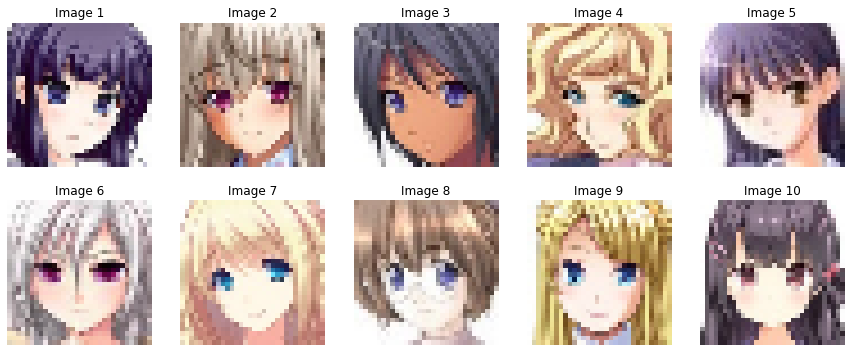

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
      ax[i, j].imshow(ae_train[i*5 + j])
      ax[i, j].axis('off')
      ax[i, j].set_title(f'Image {i*5 + j + 1}')
plt.show()

#Encoder Part

In [ ]:
latentDim = 16
inputShape = (hight, hight, 3)
chanDim = 3
depth = 1

In [ ]:
inputs = Input(shape=inputShape)
x = inputs

x = Conv2D(16, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=3)(x)

x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latentDim)(x)

In [ ]:
encoder = Model(inputs, latent, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 16)        0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                           

#Decoder part

In [ ]:
latentInputs = Input(shape=(latentDim,))
x = Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

In [ ]:
x = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(16, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

In [ ]:
x = Conv2DTranspose(3, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)

In [ ]:
decoder = Model(latentInputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              34816     
                                                                 
 reshape (Reshape)           (None, 8, 8, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 32)       9248      
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                           

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 16)                38064     
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         49315     
                                                                 
Total params: 87,379
Trainable params: 87,187
Non-trainable params: 192
_________________________________________________________________


#Spliting datasets

In [ ]:
EPOCHS = 100
Batch_Size = 32

In [ ]:
encoder.build(inputShape)
decoder.build(inputShape)
autoencoder.build(inputShape)

In [ ]:
autoencoder.compile(loss="mse", optimizer=Adam(learning_rate=1e-3))

In [ ]:
!mkdir checkpoints
!mkdir logs
!mkdir logs/fit

In [ ]:
def show_prediction(epoch, logs):
    if epoch % 10 == 1:
        decoded_imgs = autoencoder.predict(ae_dataset[:4])
        n = 10  # number of digits to display
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(ae_dataset[i].reshape(hight, hight))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[i].reshape(hight, hight))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()


In [ ]:
checkpoint_path = "/content/drive/MyDrive/AutoEncoders/best_model.h5"
log_dir = '/content/logs/'

In [ ]:
mc = ModelCheckpoint('checkpoints/weights{epoch:03d}.h5', save_weights_only=True, period=10)
early_stop = EarlyStopping(monitor='val_loss', patience=4)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

i load the latest best model

In [ ]:
filename = 'best_model.h5'
!cp -r /content/drive/MyDrive/AutoEncoders/best_model.h5 /content
print(f'The file {filename} was copied.')


The file best_model.h5 was copied.


if the file doesn't exist we just train from scratch

In [ ]:
if os.path.exists(filename) and (not scratch):
    autoencoder.load_weights('/content/best_model.h5')

In [ ]:
log_dir = "/content/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
if wannaTrain:
	history = autoencoder.fit(
		x= ae_train,
		y= ae_train, 
		epochs=EPOCHS,
		validation_data=(ae_test, ae_test),
		batch_size=Batch_Size,
		callbacks=[mc, early_stop, checkpoint, tensorboard_callback, lr_reduce])

In [ ]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(ae_vali[:25])
outputs = None

[INFO] making predictions...
1/1 [==============================] - 0s 41ms/step


In [ ]:
decoded.shape

(25, 32, 32, 3)

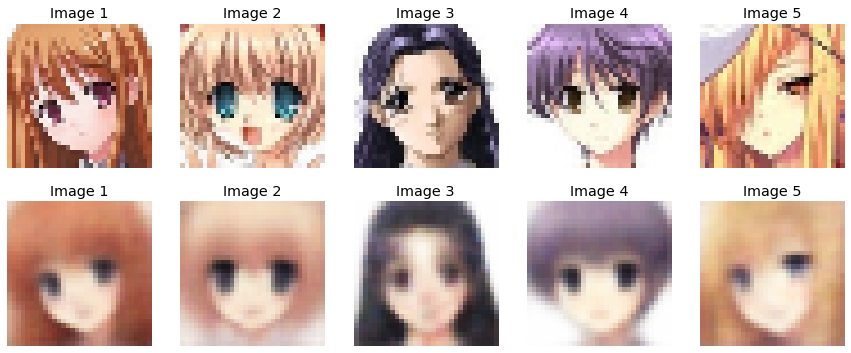

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
      if i == 0:
        ax[i, j].imshow(ae_vali[0*5 + j])
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Image {0*5 + j + 1}')
      else:
        ax[i, j].imshow(decoded[0*5 + j])
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Image {0*5 + j + 1}')

plt.show()